In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime

In [18]:
# Load stock price data from Yahoo Finance using yfinance library
import yfinance as yf
ticker_symbol = "ITC.NS"  # Change to the stock symbol you want to predict
start_date = "2023-01-10"
end_date = "2023-10-10"
data = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [19]:
# Extract the 'Close' price column
df = data[['Close']]

In [20]:
# Data preprocessing
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

C:\Users\Vasan\AppData\Local\Temp\ipykernel_22016\341454535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))


In [21]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df[:train_size].values
test_data = df[train_size:].values

In [22]:
# Function to create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Adjust the sequence length as needed
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [23]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
3/3 [==============================] - 5s 18ms/step - loss: 0.2314
Epoch 2/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0766
Epoch 3/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0083
Epoch 4/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0380
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0150
Epoch 6/50
3/3 [==============================] - 0s 13ms/step - loss: 0.0058
Epoch 7/50
3/3 [==============================] - 0s 13ms/step - loss: 0.0137
Epoch 8/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0152
Epoch 9/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0094
Epoch 10/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0049
Epoch 11/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0062
Epoch 12/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0077
Epoch 13/50
3/3 [==============================] - 0s 16ms/st

In [26]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


1/1 [==============================] - 1s 917ms/step - loss: 0.0022
Test Loss: 0.002179048489779234


In [27]:
# Make predictions
predictions = model.predict(X_test)

1/1 [==============================] - 1s 868ms/step


In [28]:
# Inverse transform the scaled predictions to get actual stock prices
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

In [29]:
test_dates = data.index[-len(y_test):] 

In [30]:
formatted_dates = [date.strftime("%Y.%m.%d") for date in test_dates]

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, '2023.08.30'),
  Text(1, 0, '2023.08.31'),
  Text(2, 0, '2023.09.01'),
  Text(3, 0, '2023.09.04'),
  Text(4, 0, '2023.09.05'),
  Text(5, 0, '2023.09.06'),
  Text(6, 0, '2023.09.07'),
  Text(7, 0, '2023.09.08'),
  Text(8, 0, '2023.09.11'),
  Text(9, 0, '2023.09.12'),
  Text(10, 0, '2023.09.13'),
  Text(11, 0, '2023.09.14'),
  Text(12, 0, '2023.09.15'),
  Text(13, 0, '2023.09.18'),
  Text(14, 0, '2023.09.20'),
  Text(15, 0, '2023.09.21'),
  Text(16, 0, '2023.09.22'),
  Text(17, 0, '2023.09.25'),
  Text(18, 0, '2023.09.26'),
  Text(19, 0, '2023.09.27'),
  Text(20, 0, '2023.09.28'),
  Text(21, 0, '2023.09.29'),
  Text(22, 0, '2023.10.03'),
  Text(23, 0, '2023.10.04'),
  Text(24, 0, '2023.10.05'),
  Text(25, 0, '2023.10.06'),
  Text(26, 0, '2023.10.09')])

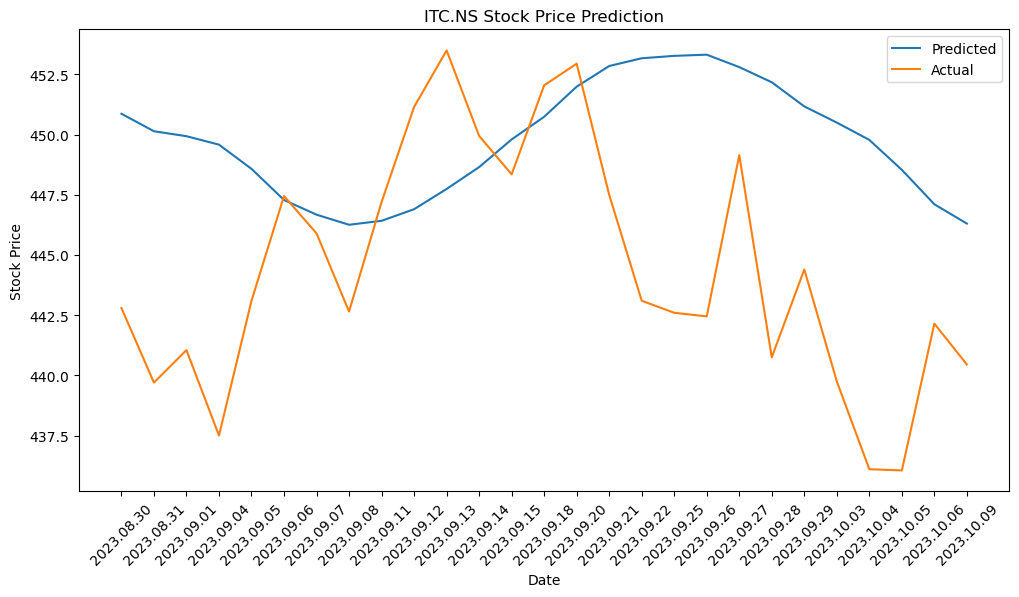

In [31]:
# Plot the actual vs. predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(formatted_dates, predictions, label='Predicted')
plt.plot(formatted_dates, y_test, label='Actual')
plt.legend()
plt.title(f'{ticker_symbol} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)

In [32]:
forecasted_value = predictions[-1][0]
print(f'Forecasted Value (Next Day): {forecasted_value}')

plt.show()

Forecasted Value (Next Day): 446.3055725097656
